In [4]:
# Step 1: Clone the specific branch hackathon-prep
!git clone --branch hackathon-prep https://github.com/adamimos/epsilon-transformers.git
%cd epsilon-transformers

# Step 2: Install the necessary dependencies
!pip install -e .

# Step 3: Install gdown if not already installed
#!pip install gdown

# Step 4: Download the RRXOR experiment data
#!gdown "https://drive.google.com/uc?id=1PYMcdvvJ_FW31rQDBmnNKz9LOyFEcfqQ" -O vfs4q106-rrxor.zip

# Step 5: Unzip the data in the correct location
#!unzip vfs4q106-rrxor.zip -d examples/models/


Cloning into 'epsilon-transformers'...
remote: Enumerating objects: 5666, done.
remote: Counting objects: 100% (1049/1049), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 5666 (delta 554), reused 889 (delta 527), pack-reused 4617
Receiving objects: 100% (5666/5666), 242.68 MiB | 13.71 MiB/s, done.
Resolving deltas: 100% (3191/3191), done.
/content/epsilon-transformers
Obtaining file:///content/epsilon-transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
from epsilon_transformers.process.processes import ZeroOneR, GoldenMean, Mess3


In [6]:
from epsilon_transformers.process.Process import Process
import numpy as np

class GluedProcess(Process):
  def __init__(self, proc1, proc2, join_on=dict(), weights=(0.5,0.5)):
        # join_on is a dictionary that maps vocubulary from Process 2 to Process 1
        # So join_on = {0: 1} means that emitting a "0" in Process 2 looks the same
        # as emitting a "1" in Process 1, but all other vocubulary of Process 1
        # is discernable.

        self.name = proc1.name + "+" + proc2.name
        self.proc1 = proc1
        self.proc2 = proc2
        self.weights = weights
        self.join_on = join_on
        super().__init__()

  def _create_hmm(self):
        n_states = len(self.proc1.state_names_dict)
        state_names = self.proc1.state_names_dict.copy()
        for key, val in self.proc2.state_names_dict.items():
          # choose a unique name for merged state in case it is already occupied
          while key in state_names:
            key += "_"
          state_names[key] = n_states
          n_states += 1

        # For a combination in which the vocabulary is disjoint, the vocab
        # size is the sum, else the larger of the two
        vocab_len = self.proc1.vocab_len + self.proc2.vocab_len - len(self.join_on)
        T = np.zeros((vocab_len, n_states, n_states))

        # Copying over values from Proc1
        shape1 = self.proc1.transition_matrix.shape
        print(shape1)
        T[:shape1[0],:shape1[1],:shape1[2]] = self.proc1.transition_matrix

        # Copying from Proc2
        new_v = 0 # This counts the number of new vocabulary tokens
        for v in range(self.proc2.vocab_len):
          if v in self.join_on:
            T[self.join_on[v],shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
          else:
            T[shape1[0]+new_v,shape1[1]:, shape1[2]:] = self.proc2.transition_matrix[v,:,:]
            new_v += 1

        print(T)
        return T, state_names

  @property
  def steady_state_vector(self):
      steady_state_vector = np.concatenate((self.proc1.steady_state_vector * self.weights[0], self.proc2.steady_state_vector * self.weights[1]))
      #steady_state_vector = np.ones((self.num_states))

      out = steady_state_vector / steady_state_vector.sum()
      assert out.ndim == 1
      assert len(out) == self.num_states
      return out


class BiasedCoin(Process):
    def __init__(self, bias: float = 0.5):
        self.name = "bc"
        self.p = bias
        super().__init__()

    def _create_hmm(self):
        T = np.zeros((2, 1, 1))
        state_names = {"0": 0}
        T[0, state_names["0"], state_names["0"]] = self.p
        T[1, state_names["0"], state_names["0"]] = 1-self.p

        return T, state_names

class D3(Process):
    def __init__(self,a,b):
        self.name = "d3"
        self.a = a
        self.b = b
        super().__init__()

    def _create_hmm(self):
        T = np.zeros((3, 1, 1))
        state_names = {"0": 0}
        T[0, state_names["0"], state_names["0"]] = self.a
        T[1, state_names["0"], state_names["0"]] = self.b
        T[2, state_names["0"], state_names["0"]] = 1-self.a-self.b

        return T, state_names

In [7]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph

graph = transition_matrix_to_graph(transition_matrix=gp.transition_matrix,state_names=gp.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout="circular")


NameError: name 'gp' is not defined

In [ ]:
from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt

proc1 = D3(0.6,0.2)
proc2 = D3(0.2,0.6)
proc3 = D3(0.2,0.2)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0,1:1,2:2}), {0:0,1:1,2:2}, weights=(1, 2))
mixed_state_tree = process.derive_mixed_state_presentation(depth=5)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
ground_truth_simplex = _project_to_simplex(np.array(list(msp_belief_index.keys())))
plt.figure(figsize=(4.5, 4))
plt.scatter(ground_truth_simplex[0], ground_truth_simplex[1], c=[k for k in list(msp_belief_index.keys())], alpha=.75, s=5)
plt.title("Ground Truth Simplex")
plt.gca().set_axis_off()
plt.show()


Transformer training


In [ ]:
import torch
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns

import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [ ]:
def get_transformer_data_from_process(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states
    transformer_data = [x for x in tree_paths if len(x) == n_ctx+1]
    transformer_data = torch.tensor(transformer_data)
    transformer_input = transformer_data[:, :-1]
    transformer_target = transformer_data[:, 1:]
    return transformer_input, transformer_target

def get_lower_bound_for_cross_entropy(process, n_ctx):
    mixed_state_tree = process.derive_mixed_state_presentation(depth=n_ctx+1)
    myopic_entropy = mixed_state_tree.myopic_entropy
    return myopic_entropy[1:]

In [ ]:
cfg = HookedTransformerConfig(
    n_layers = 2,
    n_heads = 3,
    d_model = 9,
    d_head = 3,
    d_mlp = 9,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=3,
    n_ctx=6,
    init_weights=True,
    device=device,
    seed = 999,
)

In [ ]:
import torch
from torch.utils.data import IterableDataset, DataLoader
from typing import List, Tuple, Iterable


class ProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=10000,
                                     fixed=False)
train_dataloader = DataLoader(train_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)
val_dataset = ProcessDataset(process, sequence_length=cfg.n_ctx, num_samples=1000,
                                   fixed=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, collate_fn=process_dataset_collate_fn)

In [ ]:
proc1 = D3(0.6,0.2)
proc2 = D3(0.2,0.6)
proc3 = D3(0.2,0.2)
process = GluedProcess(proc3, GluedProcess(proc1, proc2, {0:0,1:1,2:2}), {0:0,1:1,2:2}, weights=(1, 2))
transformer_inputs, transformer_targets = get_transformer_data_from_process(process, cfg.n_ctx)
minimum_loss = np.mean(get_lower_bound_for_cross_entropy(process, cfg.n_ctx))
print(f"Minimum Loss: {minimum_loss}")
transformer_inputs = transformer_inputs.to(device)
transformer_targets = transformer_targets.to(device)

mixed_state_tree = process.derive_mixed_state_presentation(depth=cfg.n_ctx)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

In [ ]:
model = HookedTransformer(cfg)


In [ ]:
from tqdm import tqdm
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in tqdm(range(10000)):
    train_logits = model(transformer_inputs)
    train_loss = loss_fn(train_logits.view(-1, cfg.d_vocab), transformer_targets.flatten())
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{10000}, Loss: {train_loss.item()/minimum_loss*100} percent of minimum, LR: {optimizer.param_groups[0]['lr']}")
        scheduler.step()

In [291]:
import torch


# 保存整个模型到当前工作目录
filename = 'd3.pth'
torch.save(model, filename)



In [ ]:
!ls -l


total 52
drwxr-xr-x 8 root root  4096 Jun  2 19:51 epsilon-transformers
drwxr-xr-x 8 root root  4096 Jun  2 17:28 epsilon_transformers
drwxr-xr-x 2 root root  4096 Jun  2 19:55 epsilon_transformers.egg-info
drwxr-xr-x 2 root root  4096 Jun  2 17:26 examples
-rw-r--r-- 1 root root 19574 Jun  2 20:01 my_model.pth
-rw-r--r-- 1 root root   584 Jun  2 17:26 pyproject.toml
-rw-r--r-- 1 root root  2686 Jun  2 17:26 README.md
drwxr-xr-x 2 root root  4096 Jun  2 17:26 scripts
drwxr-xr-x 2 root root  4096 Jun  2 17:26 tests


In [292]:
# 加载模型
loaded_model = torch.load(filename)

# 检查模型是否相同
# 这可以通过比较某些输出或模型参数来进行
pruned_paths = tree_paths
input_example = torch.randint(low=0, high=proc1.vocab_len, size=(1, cfg.n_ctx))  # 假设词汇表大小为vocab_size
input_example = input_example.long()  # 转换输入数据类型
original_output = model(input_example)
loaded_output = loaded_model(input_example)
print(torch.equal(original_output, loaded_output))  # 输出应该是 True


True


In [294]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformer_inputs = [x for x in pruned_paths if len(x) == cfg.n_ctx]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs)
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, pruned_paths, tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")


tensor([[0, 2, 1, 2, 1, 1],
        [1, 2, 0, 1, 1, 1],
        [1, 2, 1, 1, 1, 0],
        ...,
        [0, 1, 0, 1, 2, 0],
        [2, 0, 2, 0, 0, 2],
        [2, 2, 1, 0, 0, 0]], dtype=torch.int32)
Transformer Input Beliefs: torch.Size([729, 6, 3]), Transformer Input Belief Indices: torch.Size([729, 6])


In [295]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(filename)
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid_post' in x)
print(activations.keys())


dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post'])


In [296]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions


In [297]:
acts = torch.cat([v for k, v in activations.items()], dim=-1)
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(f"Shape of belief_predictions: {belief_predictions.shape}")

Shape of belief_predictions: (729, 6, 3)


NameError: name 'regression' is not defined

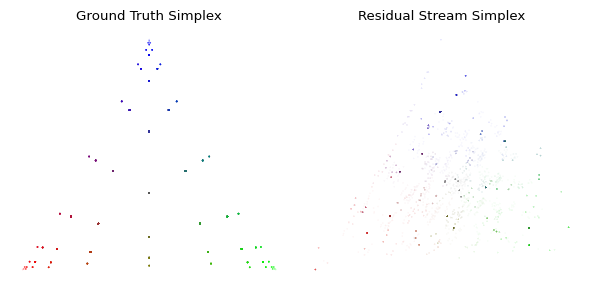

In [299]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.3, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()